## 06 Initial Model Analysis

Initial Model Analysis before class imbalance was handled. The class imbalance was severe and needed Dr. Geist's imput before moving forward with further notebooks. 

In [6]:
#Load required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, ConfusionMatrixDisplay, RocCurveDisplay, 
    PrecisionRecallDisplay
)
from xgboost import XGBClassifier

import os

#Get current working directory (.\\notebooks) -----HR
cwd = os.getcwd()

#Get parent folder to access (.\\Data) -----HR
parent = os.path.dirname(cwd)

#Get file path to load into environment -----HR
file_path = os.path.join(parent,"Data","stock_cleaned.xlsx")

#Load data into environment using the file path variable with appropriate relative path -----HR
df= pd.read_excel(file_path)

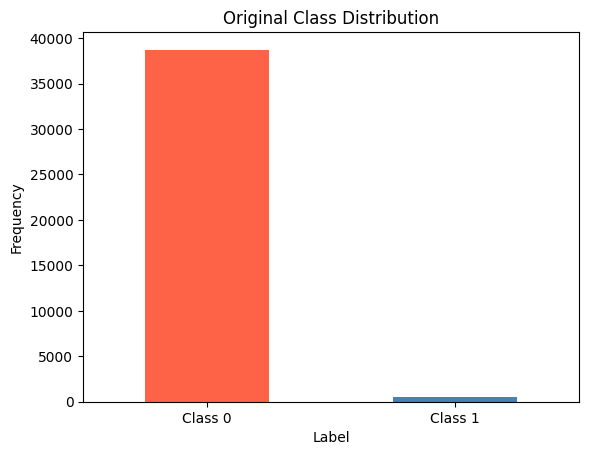

ValueError: Image size of 560x14313556 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 640x480 with 1 Axes>

In [7]:
#Separate features and labels----AP
X = df.drop("Label", axis=1)
y = df["Label"]

# 3. Visualize class distribution
y.value_counts().plot(kind="bar", color=["#FF6347", "#4682B4"])
plt.title("Original Class Distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.xticks([0, 1], ["Class 0", "Class 1"], rotation=0)
plt.show()

counts = y.value_counts()
for index, value in enumerate(counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

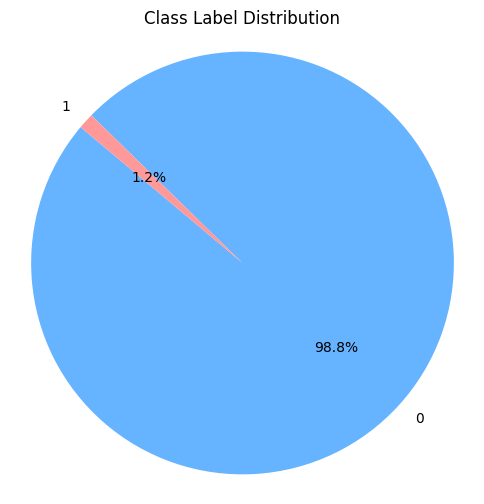

In [8]:
#Create pie chart showcasing class imbalance ----HR
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#ff9999'])
plt.title('Class Label Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()

 Train/Test Split (with Stratification)

In [9]:
#----AP
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Balance the Training Data with SMOTE

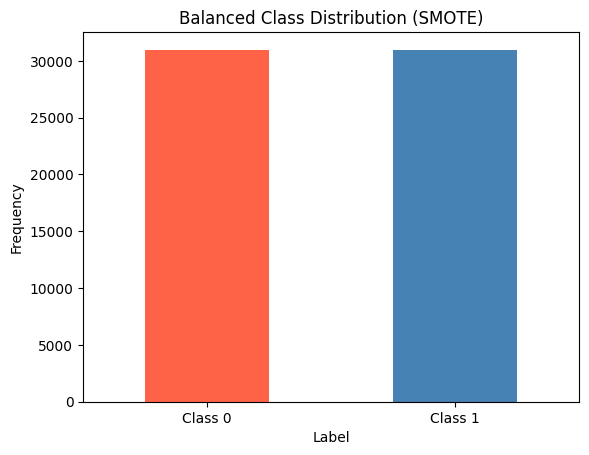

In [10]:
#----AP
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Visualize balanced classes
y_train_balanced.value_counts().plot(kind="bar", color=["#FF6347", "#4682B4"])
plt.title("Balanced Class Distribution (SMOTE)")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.xticks([0, 1], ["Class 0", "Class 1"], rotation=0)
plt.show()


Train Initial Model (Elastic Net Logistic Regression)

In [11]:
#----AP
model = LogisticRegressionCV(
    cv=5,
    class_weight="balanced",
    penalty="elasticnet",
    solver="saga",
    l1_ratios=[.1, .5, .9],
    scoring="average_precision",  # good for imbalanced
    max_iter=10000,
    random_state=42
)

# Fit model on balanced data
model.fit(X_train_balanced, y_train_balanced)


LogisticRegressionCV(class_weight='balanced', cv=5, l1_ratios=[0.1, 0.5, 0.9],
                     max_iter=10000, penalty='elasticnet', random_state=42,
                     scoring='average_precision', solver='saga')

 Evaluate the Model

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.04      0.07      7746
           1       0.01      0.98      0.02        94

    accuracy                           0.05      7840
   macro avg       0.50      0.51      0.05      7840
weighted avg       0.98      0.05      0.07      7840

ROC AUC Score: 0.47951310491070204
PR AUC Score: 0.011153146650591838


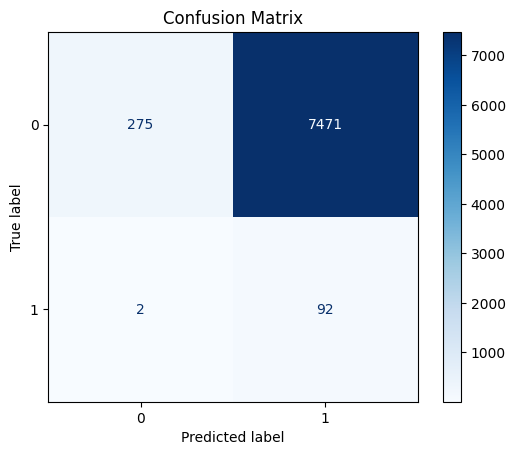

In [12]:
#Evaluate ----AP
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("PR AUC Score:", average_precision_score(y_test, y_proba))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


ROC and PR Curves

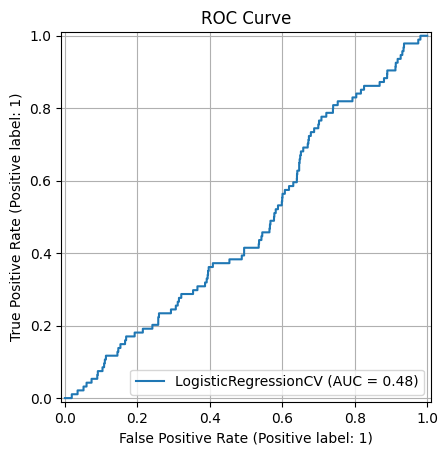

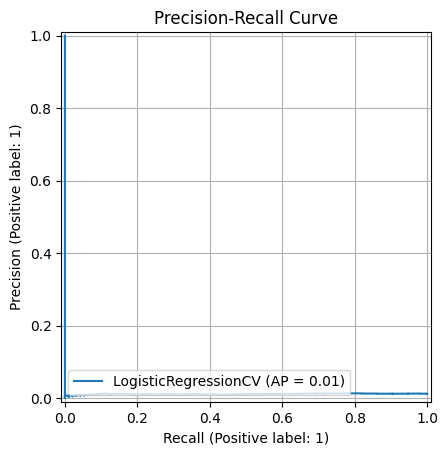

In [13]:
# ROC Curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


Trying a Lower Threshold

In [14]:
threshold = 0.4  # try 0.5, 0.6, etc.
y_pred_thresh = (y_proba >= threshold).astype(int)

print("Adjusted Threshold Classification Report:\n")
print(classification_report(y_test, y_pred_thresh))


Adjusted Threshold Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.03      0.05      7746
           1       0.01      0.98      0.02        94

    accuracy                           0.04      7840
   macro avg       0.50      0.50      0.04      7840
weighted avg       0.98      0.04      0.05      7840



Feature Importance (Optional for ElasticNet)

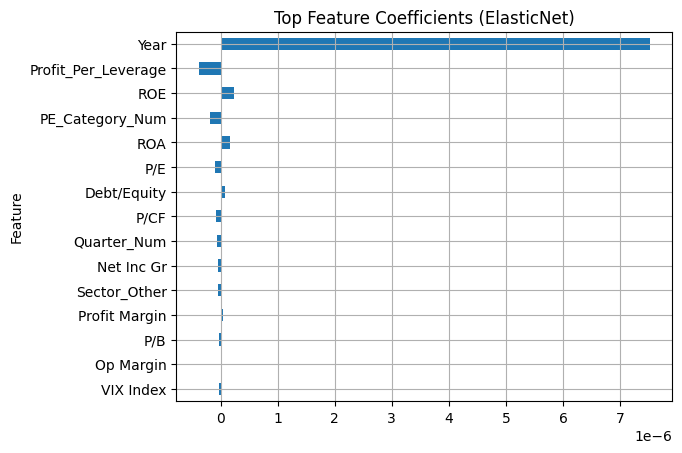

In [15]:
# Get coefficients from trained model
coefs = model.coef_.flatten()
features = X.columns

# Combine into dataframe for sorting
coef_df = pd.DataFrame({"Feature": features, "Coefficient": coefs})
coef_df["AbsValue"] = np.abs(coef_df["Coefficient"])
coef_df = coef_df.sort_values(by="AbsValue", ascending=False)

# Plot top 15
top_n = 15
coef_df.head(top_n).plot(kind="barh", x="Feature", y="Coefficient", legend=False)
plt.title("Top Feature Coefficients (ElasticNet)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


Handle Imbalance in XGBoost (scale_pos_weight)

In [16]:
# Calculate scale_pos_weight for imbalance handling
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 81.96031746031746


 Train the XGBoost Model

In [17]:
#XGBoost -----AP
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)


c:\Users\Hayden Realmuto\Documents\GitHub\team_lambda\teamlambdavenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:18:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluate the Model

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7746
           1       0.41      0.36      0.39        94

    accuracy                           0.99      7840
   macro avg       0.70      0.68      0.69      7840
weighted avg       0.99      0.99      0.99      7840

ROC AUC Score: 0.859363240327197
PR AUC Score: 0.26620343809015146


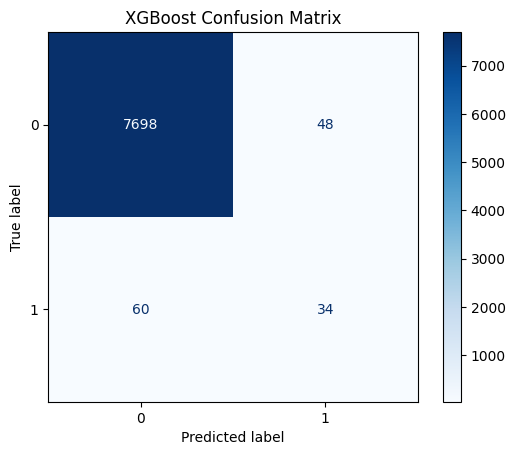

In [18]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("PR AUC Score:", average_precision_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()


ROC and PR Curves

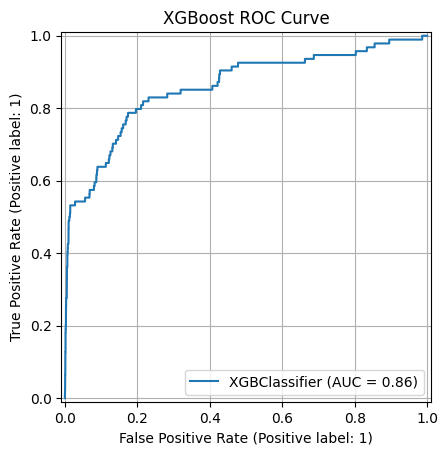

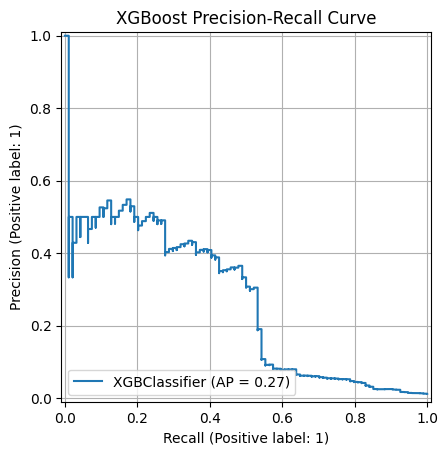

In [19]:
# ROC Curve
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("XGBoost ROC Curve")
plt.grid(True)
plt.show()

# PR Curve
PrecisionRecallDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("XGBoost Precision-Recall Curve")
plt.grid(True)
plt.show()


Feature Importance

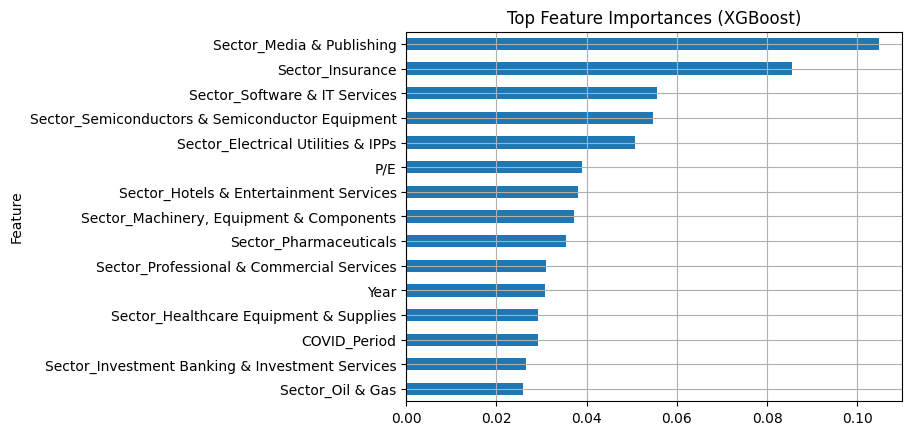

In [20]:
importances = xgb_model.feature_importances_
features = X.columns

# Create dataframe
feat_imp = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 15
feat_imp.head(15).plot(kind="barh", x="Feature", y="Importance", legend=False)
plt.title("Top Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()
